# Lab 5

## Data Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('HistoricalQuotes.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [4]:
from sklearn.preprocessing import MinMaxScaler

# parse Date and sort chronologically (oldest first) to avoid temporal leakage
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# detect the close column (handles variants like "Close/Last" or leading/trailing spaces)
close_col = next((c for c in df.columns if 'close' in c.lower()), None)
if close_col is None:
  raise KeyError("No column containing 'close' found in df.columns")

# clean dollar signs/commas and convert to float
df['Close'] = df[close_col].astype(str).str.replace(r'[\$,]', '', regex=True).str.strip().astype(float)

# normalize Close to [0,1] using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# chronological split: 80% train, 20% test
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# target arrays for modeling (scaled)
y_train = train_df['Close_scaled'].values
y_test = test_df['Close_scaled'].values

print(f"Total samples: {len(df)}, train: {len(train_df)}, test: {len(test_df)}")

Total samples: 2518, train: 2014, test: 504


## Create Training Sequences

In [5]:
import numpy as np

# sequence length (days)
sequence_length = 60

def create_sequences(series, seq_length):
  """
  Convert a 1D series (pd.Series or 1D array) into sliding window sequences.
  Each sequence of length `seq_length` predicts the next value.
  Returns X shaped (n_samples, seq_length, 1) and y shaped (n_samples,).
  """
  arr = series.values if hasattr(series, "values") else np.array(series)
  X, y = [], []
  for i in range(len(arr) - seq_length):
    X.append(arr[i : i + seq_length])
    y.append(arr[i + seq_length])
  X = np.array(X)
  y = np.array(y)
  if X.ndim == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))
  return X, y

# use the already-prepared scaled close values
X_train_seq, y_train_seq = create_sequences(train_df['Close_scaled'], sequence_length)
X_test_seq, y_test_seq = create_sequences(test_df['Close_scaled'], sequence_length)

print("Sequence length:", sequence_length)
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

Sequence length: 60
X_train_seq shape: (1954, 60, 1)
y_train_seq shape: (1954,)
X_test_seq shape: (444, 60, 1)
y_test_seq shape: (444,)


## Build the RNN Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# define RNN regression model
model = Sequential([
  SimpleRNN(50, input_shape=(sequence_length, 1)),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Epoch 1/50
62/62 - 4s - 63ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 2/50
62/62 - 0s - 8ms/step - loss: 1.5008e-04 - val_loss: 0.0066
Epoch 3/50
62/62 - 1s - 10ms/step - loss: 1.4314e-04 - val_loss: 0.0053
Epoch 4/50
62/62 - 1s - 9ms/step - loss: 1.3257e-04 - val_loss: 0.0055
Epoch 5/50
62/62 - 0s - 7ms/step - loss: 1.0353e-04 - val_loss: 0.0042
Epoch 6/50
62/62 - 0s - 6ms/step - loss: 9.8226e-05 - val_loss: 0.0040
Epoch 7/50
62/62 - 0s - 7ms/step - loss: 9.7415e-05 - val_loss: 0.0028
Epoch 8/50
62/62 - 0s - 6ms/step - loss: 9.0307e-05 - val_loss: 0.0028
Epoch 9/50
62/62 - 0s - 6ms/step - loss: 8.9395e-05 - val_loss: 0.0026
Epoch 10/50
62/62 - 0s - 6ms/step - loss: 7.9855e-05 - val_loss: 0.0019
Epoch 11/50
62/62 - 0s - 6ms/step - loss: 7.6423e-05 - val_loss: 0.0021
Epoch 12/50
62/62 - 0s - 6ms/step - loss: 7.1387e-05 - val_loss: 0.0016
Epoch 13/50
62/62 - 0s - 6ms/step - loss: 7.1976e-05 - val_loss: 0.0013
Epoch 14/50
62/62 - 0s - 6ms/step - loss: 7.3205e-05 - val_loss: 9.9231e-04

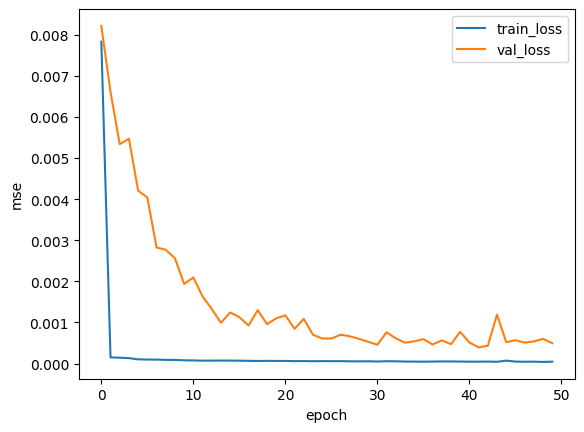

In [7]:
# train for 50 epochs with validation on the test sequences
history = model.fit(
  X_train_seq, y_train_seq,
  epochs=50,
  batch_size=32,
  validation_data=(X_test_seq, y_test_seq),
  verbose=2
)

# plot training and validation loss to inspect overfitting
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

## Make Predictions:

MSE: 43.8089, MAE: 4.8804


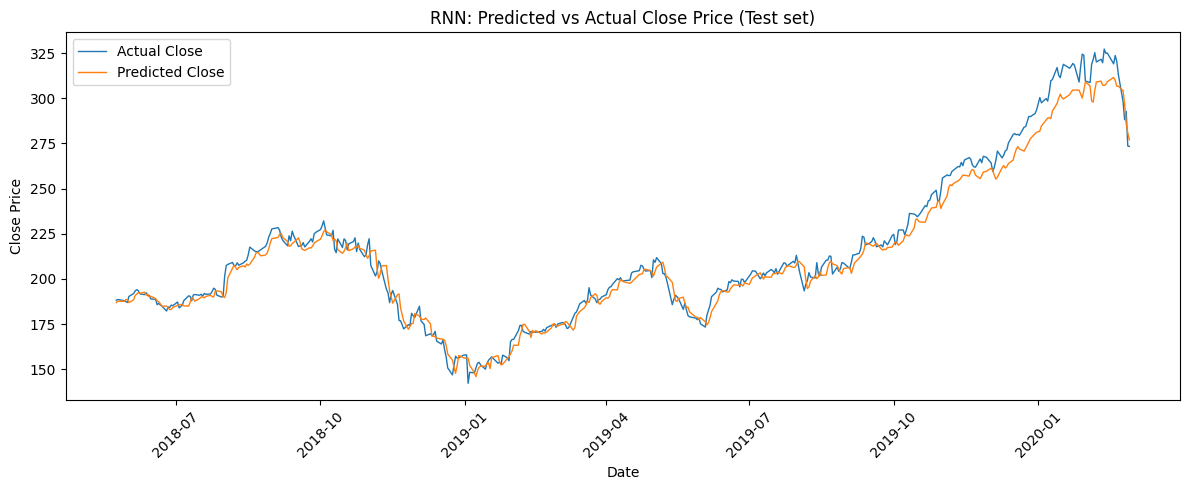

In [ ]:
# predict on test sequences, inverse transform to original price scale, and plot
y_pred_scaled = model.predict(X_test_seq, verbose=0)        # shape (n_samples, 1)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()  # original Close values

# inverse transform the ground-truth scaled targets
y_test_orig = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# corresponding dates for the y_test_seq predictions (skip first `sequence_length` rows of test_df)
test_dates = test_df['Date'].iloc[sequence_length:].reset_index(drop=True)

# basic error metrics
mse = np.mean((y_test_orig - y_pred) ** 2)
mae = np.mean(np.abs(y_test_orig - y_pred))
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# plot predicted vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test_orig, label='Actual Close', linewidth=1)
plt.plot(test_dates, y_pred, label='Predicted Close', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('RNN: Predicted vs Actual Close Price (Test set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluation:

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# predict (scaled) and inverse-transform to original price units
y_pred_scaled = model.predict(X_test_seq, verbose=0).reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# relative errors for context
mean_price = y_true.mean()
print(f"Mean actual price (test): {mean_price:.4f}")
print(f"MAE as % of mean price:  {mae / mean_price * 100:.2f}%")
print(f"RMSE as % of mean price: {rmse / mean_price * 100:.2f}%")

# short assessment
print("\nAssessment:")
print("MAE gives the average absolute error in price units; RMSE penalizes larger errors more.")
print("If MAE/RMSE are small relative to typical daily price moves (or mean price), the model is useful;")
print("otherwise it indicates limited predictive accuracy and likely room for model/data improvements.")

Test MAE:  4.8804
Test RMSE: 6.6188
Mean actual price (test): 214.3790
MAE as % of mean price:  2.28%
RMSE as % of mean price: 3.09%

Assessment:
MAE gives the average absolute error in price units; RMSE penalizes larger errors more.
If MAE/RMSE are small relative to typical daily price moves (or mean price), the model is useful;
otherwise it indicates limited predictive accuracy and likely room for model/data improvements.


## Results summary
- Dataset and setup: chronological 80/20 split (train: 2014 samples, test: 504 samples), sequence length = 60 days
- Single-feature (Close) scaled with MinMaxScaler. 
- Model: a small RNN regression (SimpleRNN(50) → Dense(1)), trained for 50 epochs with batch_size=32.
- Qualitative behavior: the model captures broad trends in the test set and often follows the direction of medium-term price movement. 
- Predictions are smoothed relative to the ground truth and exhibit lagging behavior around quick reversals or volatile periods.

### Key quantitative observations
- Evaluation used MAE and RMSE (computed on inverse-transformed prices) and relative error as a percentage of mean test price. These metrics provide interpretable error magnitudes in price units and contextualize them relative to mean price levels.
- Training/validation loss curves were plotted; the recorded behavior (loss shapes) is useful to determine underfitting vs overfitting.

### Observed limitations and methodological issues
- Model choice and capacity: SimpleRNN is prone to vanishing gradients and less capable of learning long dependencies compared with LSTM/GRU or temporal convolution/transformer-based models. The current single-layer, single-feature model is limited and produces smooth, lagged forecasts.
- Input features: only past Close values are used. Important explanatory information (volume, technical indicators, macro/news features) is omitted, limiting predictive signal.
- Data size: although multi-year, effective supervised samples are limited once windows are created; deep models may be underpowered by available labeled samples.

### Recommended next steps
- Try LSTM/GRU or temporal CNNs and add dropout/regularization; perform hyperparameter search.